# Differentiable quantum computing with PennyLane

In this tutorial we will:

* learn step-by-step how quantum computations are implemented in PennyLane,
* understand parameter-dependent quantum computations ("variational circuits"), 
* build our first quantum machine learning model, and
* compute its gradient.

We need the following imports:

In [42]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## 1. Quantum nodes

In PennyLane, a *quantum node* is a computational unit that involves the construction, evaluation, pre- and postprocessing of quantum computations.

A quantum node consists of a *quantum function* that defines a circuit, as well as a *device* on which it is run. 

There is a growing [device ecosystem](https://pennylane.ai/plugins.html) which allows you to change only one line of code to dispatch your quantum computation to local simulators, remote simulators and remote hardware from different vendors.

Here we will use the built-in `default.qubit` device.

In [18]:
dev = qml.device('default.qubit', wires=2)

To combine the device with a quantum function to a quantum node we can use the `qml.qnode` decorator. The function can then be evaluated as if it was any other python function. Internally, it will construct a circuit and run it on the device.

In [19]:
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    return qml.probs(wires=[0, 1])

circuit()

tensor([0.5, 0. , 0.5, 0. ], requires_grad=True)

## 2. Building quantum circuits

### The initial state

<br />
<img src="figures/1.png" width="500" height="100">
<br />

The initial state has 100% probability to be measured in the "0..0" configuration. Let's see how we can verify this with PennyLane.

In [20]:
@qml.qnode(dev)
def circuit():
    return qml.probs(wires=[0, 1])

circuit()

tensor([1., 0., 0., 0.], requires_grad=True)

The internal state vector that we use to mathematically keep track of probabilities is complex-valued. Since `default.qubit` is a simulator we can have a look at the state, for example by checking the device's `state` attribute.

In [21]:
dev.state

tensor([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j], requires_grad=True)

### Unitary evolutions

<br />
<img src="figures/2.png" width="500">
<br />

Quantum circuits are represented by unitary matrices. We can evolve the initial state by an arbitrary unitrary matrix as follows:

In [22]:
s = 1/np.sqrt(2)
U = np.array([[0., -s, 0.,  s],
              [ s, 0., -s, 0.],
              [ s, 0.,  s, 0.],
              [0., -s, 0., -s]])

@qml.qnode(dev)
def circuit():
    qml.QubitUnitary(U, wires=[0, 1])
    return qml.probs(wires=[0, 1])

circuit()

tensor([0. , 0.5, 0.5, 0. ], requires_grad=True)

The internal quantum state changed.

In [23]:
dev.state

tensor([0.        +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.        +0.j], requires_grad=True)

### Measurements sample outcomes from the distribution

<br />
<img src="figures/3.png" width="500">
<br />

The most common measurement takes samples $-1, 1$ from the "Pauli-Z" observable. The samples indicate if the qubit was measured in state $| 0 \rangle$ or $| 1 \rangle$.

In [24]:
@qml.qnode(dev)
def circuit():
    qml.QubitUnitary(U, wires=[0, 1])
    return qml.sample(qml.PauliZ(wires=0)), qml.sample(qml.PauliZ(wires=1))

circuit()

tensor([[ 1, -1,  1, ..., -1,  1, -1],
        [-1,  1, -1, ...,  1, -1,  1]], requires_grad=True)

The quantum state should be still the same as above.

In [25]:
dev.state

tensor([0.        +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.        +0.j], requires_grad=True)

### Computing expectation values 

<br />
<img src="figures/4.png" width="500">
<br />

When we want outputs of computations to be deterministic, we often interpret the expected measurement outcome as the result. This value is estimated by taking lots of samples and averaging over them.

In [26]:
@qml.qnode(dev)
def circuit():
    qml.QubitUnitary(U, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliZ(wires=1))

circuit()

tensor([0., 0.], requires_grad=True)

Again, the quantum state should be the same as above.

In [27]:
dev.state

tensor([0.        +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.        +0.j], requires_grad=True)

### Quantum circuits are decomposed into gates

<br />
<img src="figures/5.png" width="500">
<br />

Quantum circuits rarely consist of one large unitary (which quickly becomes intractably large as the number of qubits grow). Instead, they are composed of *quantum gates*.

In [28]:
@qml.qnode(dev)
def circuit():
    qml.PauliX(wires=0)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=0)
    qml.PauliZ(wires=1)
    return qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliZ(wires=1))

circuit()

tensor([ 0., -1.], requires_grad=True)

### Some gates depend on "control" parameters

<br />
<img src="figures/6.png" width="500">
<br />

To train circuits, there is a special subset of gates which is of particular interest: the Pauli rotation gates. These "rotate" a special representation of the quantum state around a specific axis. The gates depend on a scalar parameter which is the angle of the rotation. 

In [29]:
@qml.qnode(dev)
def circuit(w1, w2):
    qml.RX(w1, wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(w2, wires=1)
    return qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliZ(wires=1))

circuit(0.2, 1.3)

tensor([0.98006658, 0.26216666], requires_grad=True)

The names `w1`, `w2` are already suggestive that these can be used like the trainable parameters of a classical machine learning model. But we could also call the control parameters `x1`, `x2` and encode data features into quantum states. 

## 3. A full quantum machine learning model and its gradient

Finally, we can use pre-coded routines or [templates](https://pennylane.readthedocs.io/en/stable/introduction/templates.html) to conveniently build full quantum machine learning model that include a data encoding part, and a trainable part.

<br />
<img src="figures/7.png" width="500">
<br />

Here, we will use the `AngleEmbedding` template to load the data, and the `BasicEntanglingLayers` as the trainable part of the circuit.

In [111]:
@qml.qnode(dev)
def quantum_model(x, w):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=0))


x = np.array([0.1, 0.2], requires_grad=False)
w = np.array([[-2.1, 1.2], [-1.4, -3.9], [0.5, 0.2]])

quantum_model(x, w)

tensor(0.012023, requires_grad=True)

We can draw the circuit.

In [34]:
print(quantum_model.draw())

 0: ──RX(0.1)──RX(-2.1)──╭C──RX(-1.4)──╭C──RX(0.5)──╭C──┤ ⟨Z⟩ 
 1: ──RX(0.2)──RX(1.2)───╰X──RX(-3.9)──╰X──RX(0.2)──╰X──┤     



The best thing is that by using PennyLane, we can easily compute its gradient!

In [35]:
gradient_fn = qml.grad(quantum_model)

gradient_fn(x, w)

(array([[ 1.69541373e-01, -2.77555756e-17],
        [ 6.97079563e-02, -5.37764278e-17],
        [ 1.69541373e-01, -1.97324795e-17]]),)

This allows us to slot the quantum circuit into the machine learning example from the previous notebook.

#  TASKS 

1. Copy and paste the code from the previous notebook to here and replace the classical model by 
   the `quantum_model` function. This will allow you to train the model!

2. Add a bias term to the quantum model.

3. Replace the hand-coded optimisation step by a native [PennyLane optimiser](https://pennylane.readthedocs.io/en/stable/introduction/optimizers.html).

4. Rewrite the entire example in PyTorch. 

   Tipp: You must set the qnode to the correct interface via `@qml.qnode(dev, interface='tf')`.

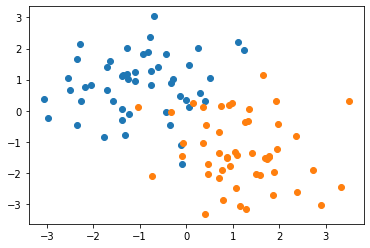

In [121]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))


plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

In [ ]:
@qml.qnode(dev)
def quantum_model(x, w):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    for weight in w:
        qml.templates.BasicEntanglerLayers(weight, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=0))

In [122]:
def model_with_bias(x, w, b):
    x = quantum_model(x, w)
    return x + b

def loss(a, b):
    return (a - b)**2

def cost(w, b, data):
    c = 0
    for x, y in data:
        prediction = model_with_bias(x, w, b)
        c += loss(prediction, y)
    return c/len(data)

In [150]:
num_layers = 3
w_init = 0.01 * np.random.random(size=(num_layers,2))) # 2 qubits / wires
b_init = np.random.random(size=(1,))

history = []
optimizer = qml.AdamOptimizer(0.1)
var = [w_init, b_init]
for i in range(10):
    var, _cost = optimizer.step_and_cost(lambda var: cost(var[0], var[1], data), var)
    print(var)
    print("\nIter: {:5d} | Cost: {:0.7f}\n".format(i, _cost[0]))
    history.append(var)
optimizer.update_stepsize(0.01)
for i in range(30):
    var, _cost = optimizer.step_and_cost(lambda var: cost(var[0], var[1], data), var)
    print(var)
    print("\nIter: {:5d} | Cost: {:0.7f}\n".format(i, _cost[0]))
    history.append(var)

[array([[0.02487647, 0.29881819],
       [0.44669609, 0.44567676]]), array([0.34862004])]

Iter:     0 | Cost: 2.0007505

[array([[-0.04932312,  0.29881819],
       [ 0.52152628,  0.44567676]]), array([0.27536252])]

Iter:     1 | Cost: 1.7329435

[array([[-0.11270006,  0.29881819],
       [ 0.58607393,  0.44567676]]), array([0.21403463])]

Iter:     2 | Cost: 1.5485587

[array([[-0.16990542,  0.29881819],
       [ 0.64481152,  0.44567676]]), array([0.16005507])]

Iter:     3 | Cost: 1.4036841

[array([[-0.22302165,  0.29881819],
       [ 0.69960155,  0.44567676]]), array([0.11137444])]

Iter:     4 | Cost: 1.2846057

[array([[-0.27315021,  0.29881819],
       [ 0.75129557,  0.44567676]]), array([0.06690526])]

Iter:     5 | Cost: 1.1850938

[array([[-0.32092873,  0.29881819],
       [ 0.80025488,  0.44567676]]), array([0.02601232])]

Iter:     6 | Cost: 1.1017078

[array([[-0.36674549,  0.29881819],
       [ 0.84656735,  0.44567676]]), array([-0.01169795])]

Iter:     7 | Cost: 1.0322

In [ ]:
num_layers = 3
w_init = 0.01 * np.random.random(size=(num_layers,2))) # 2 qubits / wires
b_init = np.random.random(size=(1,))

var = (w_init, b_init)
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5
for it in range(25):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    var, _cost = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch), var)

    print("Iter: {:5d} | Cost: {:0.7f}".format(it + 1, _cost))

[array([[-0.56165965,  0.29881819],
       [ 0.97716746,  0.44567676]]), array([-0.11866865])]
[-0.56165965  0.97716746]


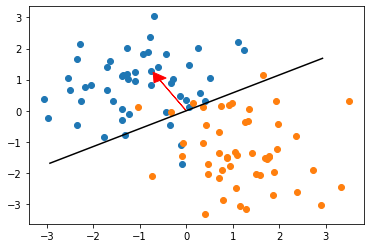

In [151]:
print(var)
w = var[0].T[0]
print(w)
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()